# Welcome on Swarmpy_tsp Onboarding

<a href="https://www.python.org/downloads/release/python-3100/" 
target="_blank"><img src="https://img.shields.io/badge/python-3.10-blue.svg" alt="Python Version" /></a>

___

First let's import the librairies we will use

In [1]:
import os 
import numpy as np
import copy
import matplotlib.pyplot as plt
os.chdir('..')

from swarmpy_tsp import *


The `ant_coder` function can load the TSP test sets of the test_set folder, namely :
- berlin52 
- ch130

`G` is the graph representation of the problem. Its a dictionnary containing a uninitalized pheromones matrix, a heuristics matrix and a cost matrix

In [2]:
G, opt_score = Antcoder('test_set/berlin52')

Ant colony optmization algorithms can be built in the same fashion as a Pipeline object. You only need to put the blocks in the right order.

For example, let's instantiate two different algorithms


> Careful ! The G dictionnary is modified inplace during computation. 

In [3]:
aco_with_Daemon = ACO_Iterator(
    [
        ("Planner", Planner({"alpha": 1.0, "beta": 2.0})),
        ("Sol", SolutionConstructor()),
        ("DA", DaemonActions()),
        ("Updater", BestTourPheromonesUpdater()),
 ]
)

aco_without_Daemon = ACO_Iterator(
    [
        ("Planner", Planner({"alpha": 1.0, "beta": 2.0})),
        ("Sol", SolutionConstructor()),
        ("Updater", BestSoFarPheromonesUpdater(k=1)),
 ]
)
aco_with_Daemon_6 = ACO_Iterator(
    [
        ("Planner", Planner({"alpha": 1.0, "beta": 6.0})),
        ("Sol", SolutionConstructor()),
        ("DA", DaemonActions()),
        ("Updater", BestTourPheromonesUpdater()),
 ]
)

aco_with_Daemon_0_5 = ACO_Iterator(
    [
        ("Planner", Planner({"alpha": 1.0, "beta": .5})),
        ("Sol", SolutionConstructor()),
        ("DA", DaemonActions()),
        ("Updater", BestTourPheromonesUpdater()),
 ]
)


SwarmPy | Best score : 6621.493929011727: 100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


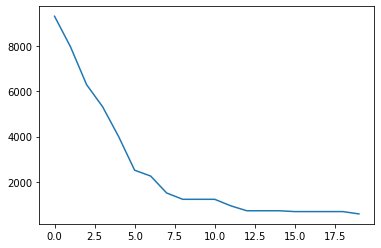

In [4]:
G1 = copy.deepcopy(G)
G2 = copy.deepcopy(G)
G3 = copy.deepcopy(G)

solutions_w_daemon = aco_with_Daemon.run(G=G, iter_max=20)
scores_w_daemon = np.array([el[1] for el in solutions_w_daemon]) - opt_score

plt.plot(scores_w_daemon)
plt.show()

In [34]:
#scores_DA_df = pd.DataFrame({'Regret with Daemon':scores_w_daemon,'Regret without Daemon':scores_wo_daemon,'Regret with Daemon _6':scores_w_daemon_6,'Regret with Daemon _0_5':scores_w_daemon_0_5 })
#px.line(scores_DA_df,y=scores_DA_df.columns, x = np.arange(len(scores_w_daemon)))